In [1]:
import sys
sys.path.insert(0, '..\\..\\frxas.py')

import numpy as np
import h5py
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, report_fit

from frxas import hdf5_io
from frxas import models
from frxas import visualization

%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
def chi_pattern(x, amp, gamma_p, ld, tg, yd, f, L):
    r"""Summarize the function in one line.

    Function for dimensionless vacancy concentrations assuming ideal behavior
    and overpotential control.

    Parameters
    ----------
    x : list or np.ndarray
        Array or list of arrays of length values.
    ld : float
        :math:`l_{\delta}` : Characteristic length scale of vacancy profile,
        often called the "utilization length".
    tg : float
        :math:`t_G`  : Characteristic time scale of vacancy profile. Reflects
        time scale of switching from kinetic limitations (low frequency) to
        co-limitation by kinetics and diffusion (moderate to high frequency).
    aoo : float
        :math:`A_o` : Thermodynamic factor.
    kappa : float
        Bleh bleah
    f : float
        Applied linear frequency in units of Hz.

    Returns
    -------
    np.ndarray
        Evaluated function for given length array and parameters.
    """
    g_p = gamma_p
    w = 2 * np.pi * f
#     ao = models.calc_ao(aoo, po2, po2_ref)

    chi = -amp /(1 +  g_p * np.sqrt(1 + 1j * tg * w)) \
    * np.exp(-(x + yd)/ ld * np.sqrt(1 + 1j * tg * w))
    # Note gamma_p = gamma * L / ld
    return chi

In [3]:
f1 = hdf5_io.get_all_datasets('July18_frXAS', start_indices =[[4, 0, 0, 3], [3, 0, 5, 0], [1, 0,2]]) # [[0,0,0,0],[0,0,0,0],[0,0,0]])#
hdf5_io.close_frxas_file('July18_frXAS')

In [4]:
x, data, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='data_adj')

In [5]:
colors = ['k', 'r', 'b', 'c']
markers = [(6, 2, 0), 's', '^', 'o']

colors = colors * (len(colors) % len(data))
markers = markers * (len(colors) % len(data))

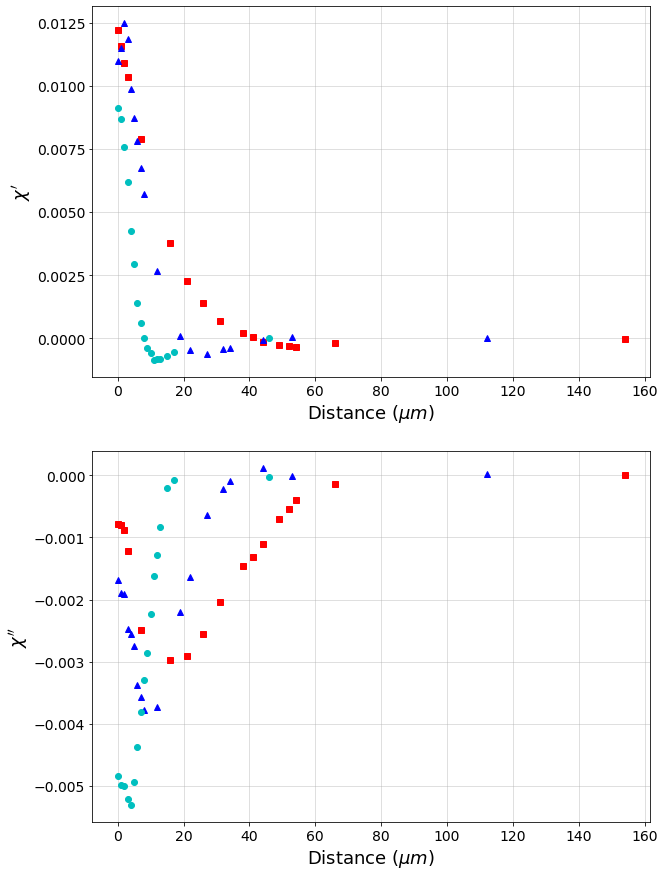

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

for iy in np.arange(1,sizes[0]):
    visualization.plot_chi(axes, x[iy], -data[iy], color=colors[iy], marker=markers[iy], ls='')
# for iy in np.arange(sizes[0],sum(sizes[:2])):
#     visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy], marker=markers[iy], ls='')
# for iy in np.arange(sum(sizes[:2]),sum(sizes)):
#     visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy], marker=markers[iy], ls='')

plt.show()

In [7]:
fit_params = Parameters()

for iy, y in enumerate(data):
    fit_params.add('amp_%i' % (iy+1), value=.005, min=0, max=1)
    fit_params.add('gamma_%i' % (iy+1), value=0.001, min=1e-9, max=0.1)
    fit_params.add('ld_%i' % (iy+1), value=15, min=1e-9, max=100)
    fit_params.add('tg_%i' % (iy+1), value=1, min=1e-9, max=10.0)
    fit_params.add('yd_%i' % (iy+1), value=0, min=-5, max=5, vary=False)
    fit_params.add('f_%i' % (iy+1), value=frequencies[iy], vary=False)
    fit_params.add('L_%i' % (iy+1), value=6e-1, vary=False)

# fit_params.add('yd_8', value=1, min=-5, max=5, vary=True)
# Setting all aoo to be equal
# for iy in np.arange(1, len(data)):
#     fit_params['aoo_%i' % (iy+1)].expr = 'aoo_1'

# Setting other parameters within each dataset to be equal
for iy in np.arange(1, sizes[0]):
    fit_params['gamma_%i' % (iy+1)].expr = 'gamma_1'
    fit_params['ld_%i' % (iy+1)].expr = 'ld_1'
    fit_params['tg_%i' % (iy+1)].expr = 'tg_1'

for iy in np.arange(sizes[0]+1, sum(sizes[:2])):
    fit_params['gamma_%i' % (iy+1)].expr = 'gamma_5'
    fit_params['ld_%i' % (iy+1)].expr = 'ld_5'
    fit_params['tg_%i' % (iy+1)].expr = 'tg_5'

for iy in np.arange(sum(sizes[:2])+1, len(data)):
    fit_params['gamma_%i' % (iy+1)].expr = 'gamma_9'
    fit_params['ld_%i' % (iy+1)].expr = 'ld_9'
    fit_params['tg_%i' % (iy+1)].expr = 'tg_9'

In [8]:
mini=lmfit.Minimizer(models.objective_fun, fit_params, fcn_args=(x, data, chi_pattern))

In [9]:
bounds = [(0,1), (1e-9, .1), (1e-2, 50), (1e-2, 10)] *11

In [10]:
out = mini.minimize(method='leastsq')
# out = mini.minimize(method='least_squares', params=out.params)
print('\u03A7_red = ', out.redchi)
report_fit(out.params)

Χ_red =  5.270996915267109e-06
[[Variables]]
    amp_1:     0.08758296 +/- 0.00246475 (2.81%) (init = 0.005)
    gamma_1:   0.04616517 +/- 0.02779716 (60.21%) (init = 0.001)
    ld_1:      38.3782253 +/- 0.51729674 (1.35%) (init = 15)
    tg_1:      2.90209438 +/- 0.58089482 (20.02%) (init = 1)
    yd_1:      0 (fixed)
    f_1:       0 (fixed)
    L_1:       0.6 (fixed)
    amp_2:     0.01242598 +/- 0.00121821 (9.80%) (init = 0.005)
    gamma_2:   0.04616517 +/- 0.02779716 (60.21%) == 'gamma_1'
    ld_2:      38.3782253 +/- 0.51729674 (1.35%) == 'ld_1'
    tg_2:      2.90209438 +/- 0.58089482 (20.02%) == 'tg_1'
    yd_2:      0 (fixed)
    f_2:       0.25 (fixed)
    L_2:       0.6 (fixed)
    amp_3:     0.01517064 +/- 0.00151011 (9.95%) (init = 0.005)
    gamma_3:   0.04616517 +/- 0.02779716 (60.21%) == 'gamma_1'
    ld_3:      38.3782253 +/- 0.51729674 (1.35%) == 'ld_1'
    tg_3:      2.90209438 +/- 0.58089482 (20.02%) == 'tg_1'
    yd_3:      0 (fixed)
    f_3:       1 (fixed)
    L

C:\Users\shadd\Anaconda3\lib\site-packages\lmfit-0.9.13-py3.6.egg\lmfit\printfuncs.py:177: RuntimeWarning: invalid value encountered in long_scalars


In [11]:
out = mini.minimize(method='differential_evolution', bounds= bounds, popsize=100, mutation=(0.1, 1.9))
# out = mini.minimize(method='least_squares', params=out.params)
print('\u03A7_red = ', out.redchi)
report_fit(out.params)

KeyboardInterrupt: 

In [117]:
out = mini.minimize(method='shgo', bounds= bounds)
# out = mini.minimize(method='least_squares', params=out.params)
print('\u03A7_red = ', out.redchi)
report_fit(out.params)

c:\users\shadd\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


Χ_red =  5.4081380508900424e-06
[[Variables]]
    amp_1:     0.09916568 +/- 0.00677259 (6.83%) (init = 0.005)
    gamma_1:   0.18332014 +/- 0.08013024 (43.71%) (init = 0.001)
    ld_1:      38.2624291 +/- 0.49251987 (1.29%) (init = 15)
    tg_1:      1.36156803 +/- 0.36382961 (26.72%) (init = 1)
    yd_1:      0 (fixed)
    f_1:       0 (fixed)
    L_1:       0.6 (fixed)
    amp_2:     0.01129824 +/- 0.00164935 (14.60%) (init = 0.005)
    gamma_2:   0.18332014 +/- 0.08013024 (43.71%) == 'gamma_1'
    ld_2:      38.2624291 +/- 0.49251987 (1.29%) == 'ld_1'
    tg_2:      1.36156803 +/- 0.36382961 (26.72%) == 'tg_1'
    yd_2:      0 (fixed)
    f_2:       0.25 (fixed)
    L_2:       0.6 (fixed)
    amp_3:     0.01535958 +/- 0.00214685 (13.98%) (init = 0.005)
    gamma_3:   0.18332014 +/- 0.08013024 (43.71%) == 'gamma_1'
    ld_3:      38.2624291 +/- 0.49251987 (1.29%) == 'ld_1'
    tg_3:      1.36156803 +/- 0.36382961 (26.72%) == 'tg_1'
    yd_3:      0 (fixed)
    f_3:       1 (fixed)
  

C:\Users\shadd\Anaconda3\lib\site-packages\lmfit-0.9.13-py3.6.egg\lmfit\printfuncs.py:177: RuntimeWarning: invalid value encountered in long_scalars


In [47]:
out.params.pretty_print()

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
L_1           0.65     -inf      inf        0    False     None     None
L_10          0.65     -inf      inf        0    False     None     None
L_11          0.65     -inf      inf        0    False     None     None
L_2           0.65     -inf      inf        0    False     None     None
L_3           0.65     -inf      inf        0    False     None     None
L_4           0.65     -inf      inf        0    False     None     None
L_5           0.65     -inf      inf        0    False     None     None
L_6           0.65     -inf      inf        0    False     None     None
L_7           0.65     -inf      inf        0    False     None     None
L_8           0.65     -inf      inf        0    False     None     None
L_9           0.65     -inf      inf        0    False     None     None
amp_1      0.08771        0        1 0.002065     True     None     None
amp_10     0.03092        0        1   0.1237    

In [30]:
axes[0].get_ylim()

(-0.0016525675347249468, 0.013603919857770598)

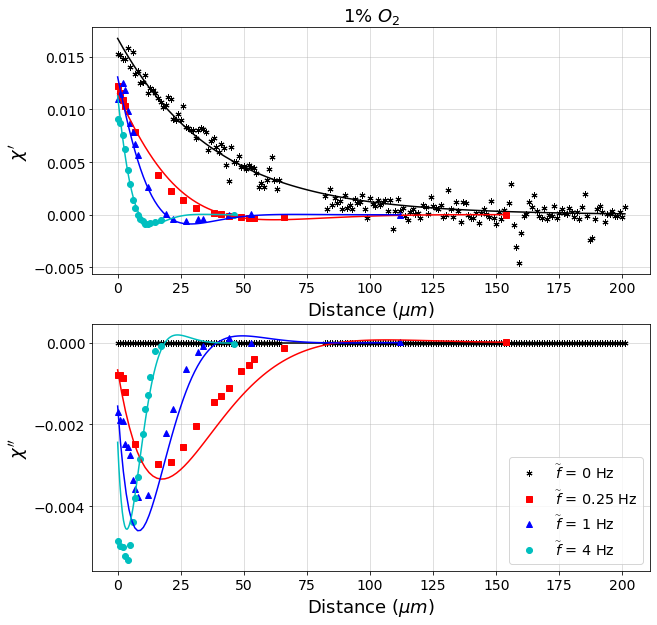

In [13]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))
DC_ind = 0
# Plotting steady-state data, scaled down by a fifth to match other profile amp
visualization.plot_chi(axes, x[DC_ind], -data[DC_ind]/5, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, -models.dataset_fun(out.params, DC_ind, y, chi_pattern)/5,
                       color=colors[0], marker='')

for iy in np.arange(1,sizes[0]):
    visualization.plot_chi(axes, x[iy], -data[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label='$\widetilde{f}$ = ' + str(frequencies[iy]) + ' Hz')
for iy in np.arange(1,sizes[0]):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, -models.dataset_fun(out.params, iy, y, chi_pattern),
                           color=colors[iy], marker='')
                           #label=str(frequencies[iy]) + ' Hz')

axes[0].set_title('1% $O_2$', fontsize=18)
plt.legend(fontsize='x-large')
# plt.show()
plt.savefig(r'Plots\Pattern Amp Model wo yd\1%O2.png', dpi=300, bbox_inches='tight')

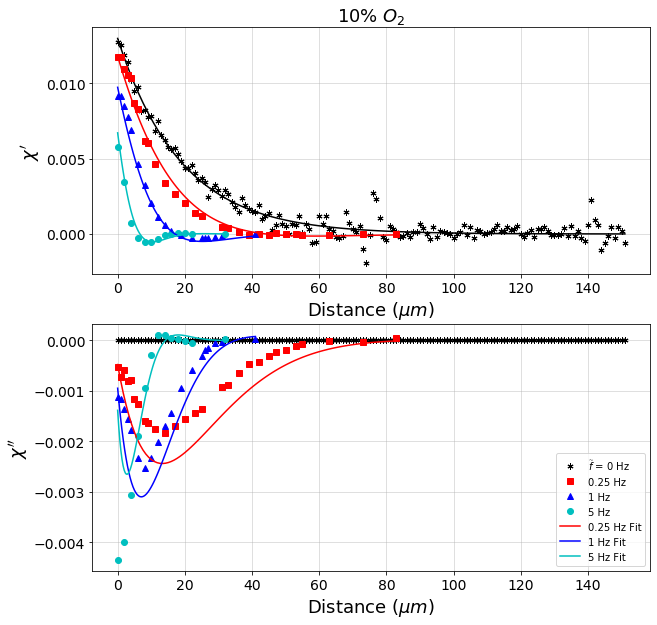

In [14]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

DC_ind = sizes[0]
# Plotting steady-state data, scaled down by a fifth to match other profile amp
visualization.plot_chi(axes, x[DC_ind], -data[DC_ind]/5, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, -models.dataset_fun(out.params, DC_ind, y, chi_pattern)/5,
                       color=colors[0], marker='')

for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
    visualization.plot_chi(axes, x[iy], -data[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label=str(frequencies[iy]) + ' Hz')

for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, -models.dataset_fun(out.params, iy, y, chi_pattern),
                           color=colors[iy], marker='',
                           label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('10% $O_2$', fontsize=18)
plt.legend()
# plt.show()
# plt.savefig(r'Plots\Pattern Amp Model wo yd\10%O2.png', dpi=300, bbox_inches='tight')

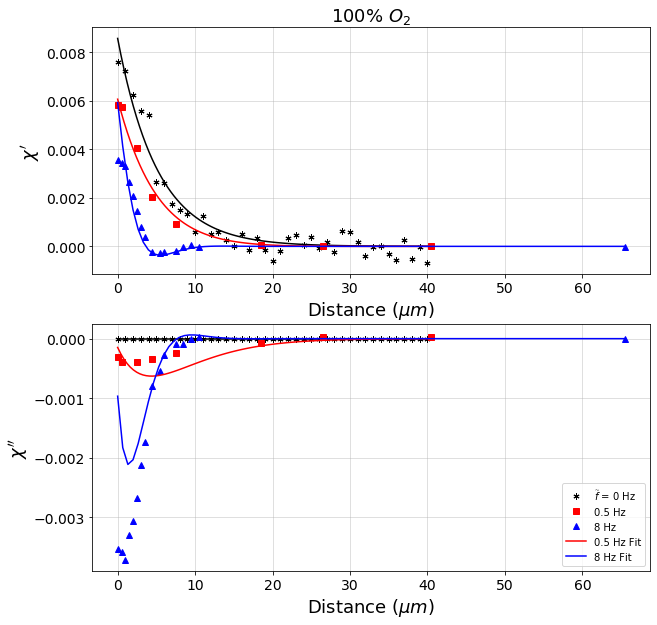

In [15]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

DC_ind = sum(sizes[:2])
# Plotting steady-state data, scaled down by a fifth to match other profile amp
visualization.plot_chi(axes, x[DC_ind], -data[DC_ind]/5, color=colors[0],
                       marker=markers[0], ls='',
                       label='$\widetilde{f}$ = ' + str(frequencies[0]) + ' Hz')
y = np.linspace(0, x[DC_ind][-1], num=100)
visualization.plot_chi(axes, y, -models.dataset_fun(out.params, DC_ind, y, chi_pattern)/5,
                       color=colors[0], marker='')


for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    visualization.plot_chi(axes, x[iy], -data[iy], color=colors[iy],
                           marker=markers[iy], ls='', 
                           label=str(frequencies[iy]) + ' Hz')
for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    y = np.linspace(0, x[iy][-1], num=100)
    visualization.plot_chi(axes, y, -models.dataset_fun(out.params, iy, y, chi_pattern),
                           color=colors[iy], marker='',
                           label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('100% $O_2$', fontsize=18)
plt.legend()
# plt.show()
# plt.savefig(r'Plots\Pattern Amp Model wo yd\100%O2.png', dpi=300, bbox_inches='tight')

In [156]:
0.05683500 * 38.3795747 / .65

3.355850966268461

In [157]:
0.14298715 * 18.9187704 / .65

4.1617554784620925

In [158]:
20.0465491 * 5.10403594 /.65

157.41278012211487

In [23]:
58.32/3329

0.01751877440672875